<a href="https://colab.research.google.com/github/ritwikraha/CV-Practice/blob/master/_Final_Getting_Started_with_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq diffusers
!pip install -qq accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 4.9 MB/s eta 0:00:00


In [ ]:
import tqdm
import torch
import PIL
import PIL.Image
import numpy as np
import diffusers
from PIL import Image
from diffusers import UNet2DModel
from diffusers import AutoPipelineForText2Image
from diffusers import DDPMPipeline
from diffusers import DDPMScheduler

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Introduction

*   In this tutorial we will be making use of the diffusers library
*   Use diffusers to generate an image
*   Learn about the model and scheduler from DDPM



## A brief Primer on Diffusion


Diffusion Models are generative models, meaning that they are used to generate data similar to the data on which they are trained. Fundamentally, Diffusion Models work by destroying training data through the successive addition of Gaussian noise, and then learning to recover the data by reversing this noising process. After training, we can use the Diffusion Model to generate data by simply passing randomly sampled noise through the learned denoising process.

> Diffusion probabilistic models are parameterized Markov chains trained to gradually denoise data. We estimate parameters of the generative process p.


The underlying model, often a neural network, is trained to predict a way to slightly denoise the image in each step. After certain number of steps, a sample is obtained as shown in the following figure.

![](https://i.imgur.com/c8dBHf0.png)
Source: https://arxiv.org/abs/2006.11239


The Diffusers library, developed by Hugging Face, is an accessible tool designed for a broad spectrum of deep learning practitioners. It emphasizes three core principles: **ease of use**, **intuitive understanding**, and **simplicity in contribution**.

In essence, the diffusion process initiates with random noise, matching the size of the intended output, which is repeatedly processed through the model. This procedure concludes after a predetermined number of steps, culminating in an output image that mirrors a sample from the model's training data distribution. For example, if the model is trained on butterfly images, the resulting image will closely resemble a butterfly.

The training phase involves exposing the model to numerous samples from a specific distribution, such as butterfly images. Post-training, this model is adept at transforming random noise into images that bear a striking resemblance to butterflies.

The workflow of a diffusion model is elegantly captured in the following illustration:

![](https://i.imgur.com/wbnbLTm.jpg)

## Diffusers

In this tutorial, we'll delve into three pivotal components of Hugging Face's diffusers library.

![](https://i.imgur.com/8aeNE20.png)

- **The role of the Model**: Simplifying the complexity, the model in a diffusion process, particularly in a type known as "DDPM", is typically not tasked with directly forecasting a marginally less noisy image. Instead, its role is to ascertain the "noise residual". This is essentially the disparity between a less noisy image and its preceding input.

- **The role of the Scheduler**: To do the denoising process, a specific noise scheduling algorithm is thus necessary and "wrap" the model to define how many diffusion steps are needed for inference as well as how to *compute* a less noisy image from the model's output. Here is where the different **schedulers** of the diffusers library come into play.

- **The role of the pipeline**: The concept of a pipeline is integral to the diffusers library. It amalgamates a model with a scheduler, streamlining the process for end-users to execute a complete denoising loop. Our journey will commence with an exploration of pipelines, progressively delving into their mechanics before shifting our focus to the nuances of models and schedulers.


Let us see how to bring this together and generate an image.

In [ ]:
pipeline = AutoPipelineForText2Image.from_pretrained(
	"runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

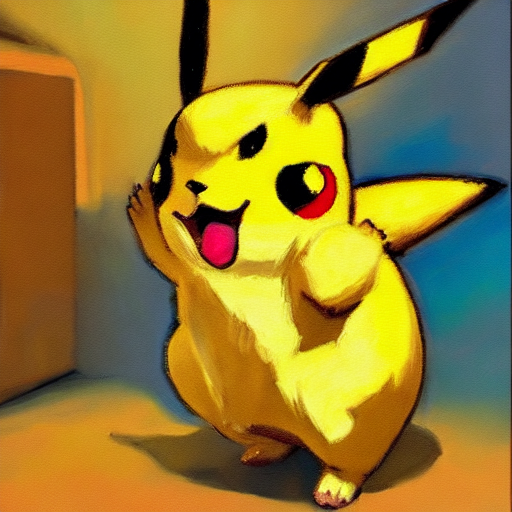

In [ ]:
image = pipeline(
	"impressionist oil painting of pikachu, backlight, centered composition, masterpiece, photorealistic, 8k"
).images[0]
image

## But what is `Autopipeline`?


The Hugging Face Diffusers library, renowned for its versatility, is capable of accomplishing a multitude of tasks. Remarkably, the same pretrained weights can often be employed for varied tasks like text-to-image, image-to-image, and inpainting. However, for those new to the library or to diffusion models, selecting the appropriate pipeline for a specific task might pose a challenge.

The `AutoPipeline` class, is designed to streamline the complexity inherent in the plethora of pipelines within the Hugging Face Diffusers framework. This class embodies a task-first approach, allowing users to concentrate on the task at hand rather than the intricacies of pipeline selection.

The ingenuity of `AutoPipeline` lies in its ability to automatically discern the most suitable pipeline class for a given task. This feature is particularly beneficial for users, as it simplifies the process of loading a model checkpoint for a specific task without the need to know the exact pipeline class name, thereby making the user experience more intuitive and accessible.

## What are some other pipelines and models?


The realm of text-to-image generation within the Hugging Face Diffusers library is rich with a variety of models, each unique in its capabilities and outputs. Among the most popular are Stable Diffusion v1.5, Stable Diffusion XL (SDXL), and Kandinsky 2.2. In addition to these, there are specialized models such as ControlNet models or adapters that can be integrated with text-to-image models to provide more precise control over image generation. While the results from each model vary due to their distinct architectures and training methodologies, their application remains largely consistent across different models.

To truly appreciate the nuances and distinctiveness of these models, let's conduct an experiment. We will use the same prompt across different models and observe the variations in the generated images. This comparison will provide insights into the strengths and characteristics of each model:

- For Stable Diffusion v1.5, we use the model identifier: `runwayml/stable-diffusion-v1-5`.
- For Stable Diffusion XL, the model identifier is: `stabilityai/stable-diffusion-xl-base-1.0`.
- And for Kandinsky 2.2, we use: `kandinsky-community/kandinsky-2-2-decoder`.

We have used the `stabilityai/stable-diffusion-xl-base-1.0` model here, but readers are encouraged to experiment with different models with the same prompts to see how the generated images differ.


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

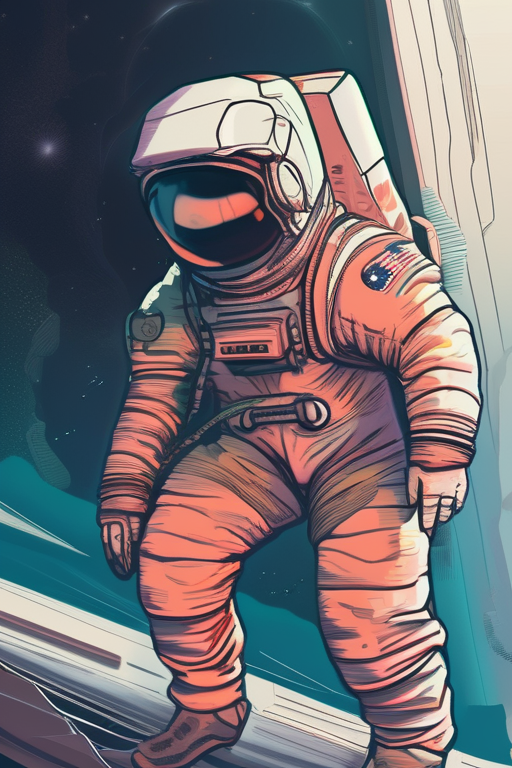

In [ ]:
pipeline = AutoPipelineForText2Image.from_pretrained(
	"stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

prompt = "Astronaut in a 1700 New York, cold color palette, muted colors, detailed, 8k"
image = pipeline(prompt = prompt,
                 height=768,
                 width=512,
                 ).images[0]
image

### Under the hood, `AutoPipelineForText2Image`:


The `AutoPipelineForText2Image` within the Hugging Face Diffusers library is ingeniously crafted to streamline the text-to-image generation process. Here's an insight into its functionality:

- **Automatic Model Detection**: This pipeline is adept at automatically identifying a "stable-diffusion" class. It achieves this by parsing through the `model_index.json` file, a key component that guides the pipeline in selecting the appropriate model.

- **Pipeline Loading**: Once the "stable-diffusion" class is identified, `AutoPipelineForText2Image` proceeds to load the corresponding `StableDiffusionPipeline`. This is directly linked to the class name "stable-diffusion", ensuring that the most suitable text-to-image pipeline is employed for the task at hand.

Additionally, `AutoPipelineForText2Image` is designed to be flexible and accommodating to specific user needs. It allows for the integration of various additional arguments that are characteristic of the pipeline class. Some notable examples include:


- `guidance_scale`: A crucial parameter, `guidance_scale` plays a pivotal role in dictating the degree to which the prompt influences the image generation. A lower value on this scale grants more creative freedom to the model, allowing it to generate images that are not strictly confined to the prompt, thus introducing a blend of creativity and abstraction.

- `num_inference_steps`: This parameter defines the number of steps the model will take during the inference process.



  0%|          | 0/70 [00:00<?, ?it/s]

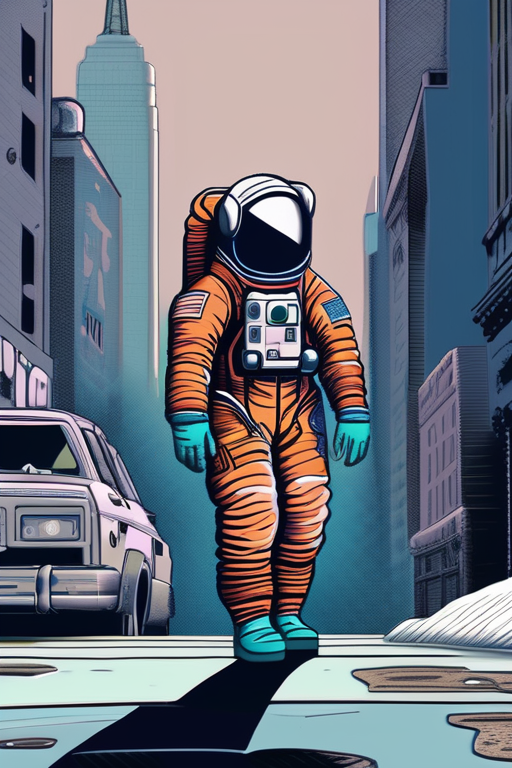

In [ ]:
image = pipeline(prompt,
                 height=768,
                 width=512,
                 num_inference_steps=70,
                 guidance_scale=10.5,
                 ).images[0]
image

## Diving Deep into a Pipeline

Now in this part of the tutorial, we will learn how to use models and schedulers to assemble a diffusion system for inference, starting with a basic pipeline.



## The DDPM Pipeline

## Getting Started with the DDPM Pipeline

In this section, we're going to explore the `Denoising Diffusion Probabilistic Models (DDPM)` pipeline using the `google/ddpm-celebahq-256` model. This model is an implementation of the DDPM algorithm, as detailed in the research paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239), and is specifically trained on a dataset comprising images of celebrities.

The `DDPMPipeline` is a simple starting point for us to understand the various aspects of the pipeline.



In [ ]:
ddpm_pipeline = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
ddpm_pipeline.to("cuda")

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.25.0",
  "_name_or_path": "google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

To generate an image, we simply run the pipeline and don't even need to give it any input, it will generate a random initial noise sample and then iterate the diffusion process.

The pipeline returns as output a dictionary with a generated `sample` of interest.

  0%|          | 0/1000 [00:00<?, ?it/s]

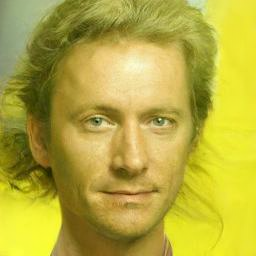

In [ ]:
images = ddpm_pipeline().images
images[0]

Let’s breakdown the pipeline and take a look at what’s happening under the hood. Here we are taking a repository from HuggingFace and extracting the `scheduler` and the `model` from it. You can take other repositories from HuggingFace to experiment.

`repo_id = "google/ddpm-church-256"`

`repo_id = "google/ddpm-cat-256"`





In [ ]:
repo_id = "google/ddpm-celebahq-256"

In [ ]:
scheduler = DDPMScheduler.from_pretrained(repo_id)
model = UNet2DModel.from_pretrained(repo_id).to("cuda")

### Models

Instances of the model class are neural networks that take a noisy `sample` as well as a `timestep` as inputs to predict a less noisy output `sample`. Let's load a pre-trained model and try to understand the API.

Here we load a simple unconditional image generation model of type `UNet2DModel` which was released with the [DDPM Paper](https://arxiv.org/abs/2006.11239) and for instance take a look at another checkpoint trained on church images: [`google/ddpm-celebahq-256`](https://huggingface.co/google/ddpm-church-256).

Similar to the pipeline class, we can load the model configuration and weights with one line, using the `from_pretrained()` method that you may be familiar with if you've played with the `transformers` library:

The `from_pretrained()` method caches the model weights locally, so if you execute the cell above a second time, it will go much faster. The model is a pure PyTorch `torch.nn.Module` class which you can see when printing out `model`.

In [ ]:
model

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsampl

### Schedulers

Schedulers play a critical role in the functioning of diffusion models, acting as the algorithmic backbone that guides both the training and inference processes. Let's delve into what schedulers are and how they operate within the diffusion framework, particularly focusing on their application during inference.


1. Schedulers are essentially algorithms encapsulated within a Python class. They meticulously define the noise schedule - a key component in the diffusion process. This noise schedule is instrumental during the model's training phase, where it dictates how noise is added to the model.

2. Besides defining the noise schedule for training, schedulers are also responsible for the computation process during inference. They take the model output, typically the noisy_residual, and compute a slightly less noisy sample from it. This step is crucial in progressively refining the image through the diffusion steps.

Distinction from Models:

It's important to distinguish schedulers from models in some key aspects:

1. Unlike models, which have trainable weights, schedulers usually do not possess any trainable parameters. Their primary function is to define the algorithmic steps for computing the less noisy sample, rather than learning from data.

2. Despite not inheriting from `torch.nn.Module` like typical neural network models, schedulers are still instantiated based on a configuration. This configuration sets the parameters for the algorithm that the scheduler will use during the inference process

To download a scheduler config from the Hub, you can make use of the `from_config()` method to load a configuration and instantiate a scheduler.

As is evident we are using `DDPMScheduler`, the denoising algorithm proposed in the [DDPM Paper](https://arxiv.org/abs/2006.11239).

In [ ]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_small'),
            ('clip_sample', True),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('timestep_spacing', 'leading'),
            ('steps_offset', 0),
            ('rescale_betas_zero_snr', False),
            ('_use_default_values',
             ['sample_max_value',
              'clip_sample_range',
              'rescale_betas_zero_snr',
              'steps_offset',
              'dynamic_thresholding_ratio',
              'prediction_type',
              'thresholding',
              'timestep_spacing']),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_versi

### Pairing Models with Schedulers

Now to summarize, **models**, such as `UNet2DModel` (PyTorch modules) are parameterized neural networks trained to *predict* a slightly less noisy image or residual. They are defined by their `.config` and can be loaded from the Hub as well as saved and loaded locally. The next step is learning how to combine this **model** with the correct **scheduler** to be able to actually generate images.

#### Creating a random noise

In [ ]:
torch.manual_seed(666)

noisy_sample = torch.randn(
    1, model.config.in_channels, model.config.sample_size, model.config.sample_size
).to("cuda")
noisy_sample.shape

torch.Size([1, 3, 256, 256])

#### Finding a resiudal noise

In [ ]:
with torch.no_grad():
    noisy_residual = model(sample=noisy_sample, timestep=2).sample

#### Using a scheduler to subtract noise

Different schedulers are usually defined by different parameters. To better understand what the parameters are used for exactly, the reader is advised to directly look into the respective scheduler files under `src/diffusers/schedulers/`, such as the [`src/diffusers/schedulers/scheduling_ddpm.py`](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddpm.py) file.



All schedulers provide one or multiple `step()` methods that can be used to compute the slightly less noisy image. The `step()` method may vary from one scheduler to another, but normally expects at least the model output, the `timestep` and the current `noisy_sample`.

If you want to understand how exactly the previous noisy sample is computed as defined in the original paper, you can check the code [here](https://github.com/huggingface/diffusers/blob/936cd08488260a9df3548d66628b83bc7f26bd9e/src/diffusers/schedulers/scheduling_ddpm.py#L130).

Let us look at the code in action.

In [ ]:
less_noisy_sample = scheduler.step(
    model_output=noisy_residual, timestep=2, sample=noisy_sample
).prev_sample
less_noisy_sample.shape

torch.Size([1, 3, 256, 256])

### The Denoising Loop

We can see that the computed sample has the exact same shape as the model input, meaning that you are ready to pass it to the model again in a next step. Let's now bring it all together and actually define the denoising loop. This loop prints out the (less and less) noisy samples along the way for better visualization in the denoising loop.





### Utility Function

 Let's define a display function that takes care of post-processing the denoised image, convert it to a `PIL.Image` and displays it.

In [ ]:
def display_sample(sample, i):

    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

### Inference from the Denoising Loop

The denoising loop described here is a crucial part of the operation in diffusion models like DDPM (Denoising Diffusion Probabilistic Models). For the DDPM variant it is actually quite simple.

Let's break down the process outlined:

1. **Predicting the Residual of the Less Noisy Sample:**
   - This step involves the model predicting the difference (residual) between the current noisy sample and a less noisy version of it. The model essentially learns how to reverse the diffusion process step by step..

2. **Computing the Less Noisy Sample with the Scheduler:**
   - The scheduler is responsible for managing the timesteps of the denoising process. It determines how the noise level decreases at each step.
   - By computing the less noisy sample, the model effectively walks back through the noise-adding process, progressively denoising the image.

3. **Displaying Progress Every 100th Step:**
   - This is a practical addition to visualize the denoising process. Since the total number of timesteps is 1000, displaying the image every 100th step allows you to observe the gradual formation of the final image from noise.
   - This visualization is akin to watching a structure being constructed gradually, where the structure (like a church) becomes more defined and clear with each step.

The looping over `scheduler.timesteps` in decreasing order is essential as it simulates the reverse of the diffusion process, starting from a completely noisy state (at the highest timestep) and gradually reducing the noise to reveal the final image.


 10%|▉         | 99/1000 [00:04<00:40, 22.09it/s]

'Image at step 100'

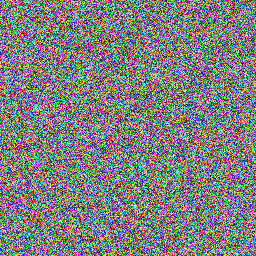

 20%|█▉        | 198/1000 [00:09<00:34, 23.41it/s]

'Image at step 200'

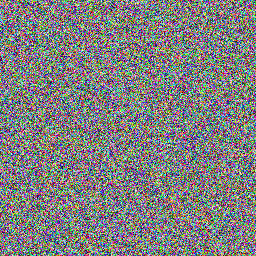

 30%|██▉       | 297/1000 [00:13<00:30, 23.28it/s]

'Image at step 300'

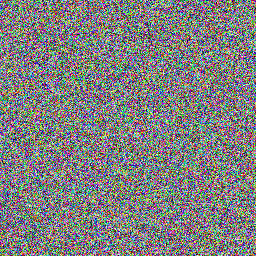

 40%|███▉      | 399/1000 [00:18<00:30, 19.53it/s]

'Image at step 400'

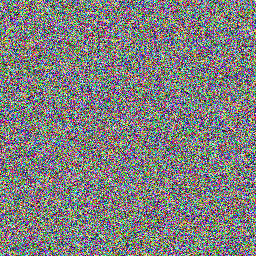

 50%|████▉     | 498/1000 [00:22<00:22, 22.48it/s]

'Image at step 500'

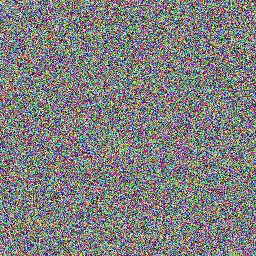

 60%|█████▉    | 597/1000 [00:27<00:17, 23.10it/s]

'Image at step 600'

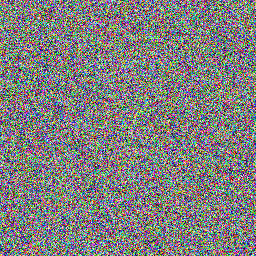

 70%|██████▉   | 697/1000 [00:31<00:15, 19.15it/s]

'Image at step 700'

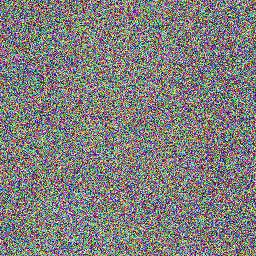

 80%|███████▉  | 798/1000 [00:36<00:08, 22.62it/s]

'Image at step 800'

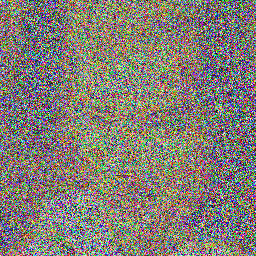

 90%|████████▉ | 897/1000 [00:41<00:04, 22.74it/s]

'Image at step 900'

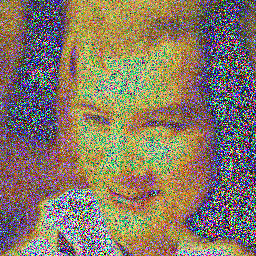

100%|█████████▉| 998/1000 [00:46<00:00, 18.95it/s]

'Image at step 1000'

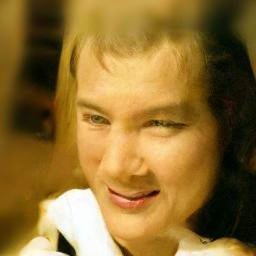

100%|██████████| 1000/1000 [00:46<00:00, 21.52it/s]


In [ ]:
sample = noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  # predict the noise residual
  with torch.no_grad():
      residual = model(sample, t).sample

  # compute the less noisy image
  # by removing the predicted noise
  # residual at the current timestep
  sample = scheduler.step(residual, t, sample).prev_sample

  # visualise the image
  if (i + 1) % 100 == 0:
      display_sample(sample, i + 1)